In [88]:
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import os
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession



In [103]:
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-19"
os.environ["SPARK_HOME"] = r"D:\sparkapp3006\venv\Lib\site-packages\pyspark"


conf = SparkConf()

sc = SparkContext.getOrCreate(conf=conf)

In [104]:
sqlContext = SQLContext(sc)
SparkSession.builder.getOrCreate()

d:\sparkapp3006\venv\Lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [91]:
df = sqlContext.read.option("inferSchema",True) \
                 .options(header='True', inferSchema='True', delimiter=';') \
                .csv(r"C:\Users\Guilh\OneDrive\Área de Trabalho\teste_01.csv")

In [93]:
df.select('ID_AGENTE', 'QTDE_VENDA', 'QTDE_LINHA', 'QTDE_LIGACOES', 'RANKING', 'Quartile').show(25)

+---------+----------+----------+-------------+-------+--------+
|ID_AGENTE|QTDE_VENDA|QTDE_LINHA|QTDE_LIGACOES|RANKING|Quartile|
+---------+----------+----------+-------------+-------+--------+
|    20931|        10|        11|          103|      1|       1|
|    20920|         8|         8|           87|      2|       1|
|    20971|         2|         3|           30|      3|       1|
|    21004|         7|         7|           98|      4|       1|
|    20808|         7|         8|          116|      5|       1|
|    20846|         5|         5|           88|      6|       1|
|    20935|         5|         5|          105|      7|       1|
|    20501|         4|         4|           87|      8|       1|
|    20673|         6|         6|          133|      9|       1|
|    21015|         5|         5|           95|     10|       1|
|    20986|         3|         3|           85|     11|       1|
|    20939|         7|         7|          193|     12|       1|
|    20937|         7|   

In [94]:
assembler = VectorAssembler(inputCols=['ID_AGENTE', 'QTDE_VENDA', 'QTDE_LINHA', 'QTDE_LIGACOES', 'RANKING', 'Quartile'], outputCol="features")
data_df = assembler.transform(df)

# features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

data_df.show(5)

+---------+------------+-------------+--------------+----------+----------+-------------+-----------------+-------+--------+--------------------+--------------------+
|ID_AGENTE|HORAS_LOGADO|HORAS_FALANDO|%_TEMPO_FALADO|QTDE_VENDA|QTDE_LINHA|QTDE_LIGACOES|%_CONVERSAO_VENDA|RANKING|Quartile|            features|     scaled_features|
+---------+------------+-------------+--------------+----------+----------+-------------+-----------------+-------+--------+--------------------+--------------------+
|    20931|        6,32|         3,07|          0,49|        10|        11|          103|              0,1|      1|       1|[20931.0,10.0,11....|[137.002998854166...|
|    20920|        8,79|         4,35|          0,49|         8|         8|           87|             0,09|      2|       1|[20920.0,8.0,8.0,...|[136.930998806992...|
|    20971|        2,24|         1,54|          0,69|         2|         3|           30|             0,07|      3|       1|[20971.0,2.0,3.0,...|[137.264817207525...

In [95]:
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.5798580850517262
Silhouette Score: 0.3788461029767778
Silhouette Score: 0.4398608244987014
Silhouette Score: 0.363078466941945
Silhouette Score: 0.4148528321346106
Silhouette Score: 0.42327641531957066


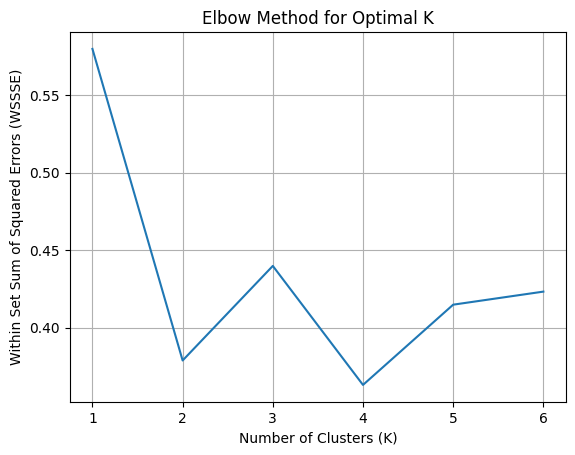

In [96]:

plt.plot(range(1, 7), wssse_values)
plt.xlabel('Numero Clusters(K)')
plt.ylabel('definindo de erros ao quadrado (WSSSE)')
plt.title('Método de Cotovelo para Optimizar K')
plt.grid()
plt.show()

In [97]:
# Definindo o modelo K-means ao cluster
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)

# Atribuindo os pontos de dados aos clusters
clustered_data = kmeans_model.transform(data_df)

In [112]:
clustered_data.show(5, truncate=False)


+---------+------------+-------------+--------------+----------+----------+-------------+-----------------+-------+--------+---------------------------------+--------------------------------------------------------------------------------------------------------------------+-------+
|ID_AGENTE|HORAS_LOGADO|HORAS_FALANDO|%_TEMPO_FALADO|QTDE_VENDA|QTDE_LINHA|QTDE_LIGACOES|%_CONVERSAO_VENDA|RANKING|Quartile|features                         |scaled_features                                                                                                     |cluster|
+---------+------------+-------------+--------------+----------+----------+-------------+-----------------+-------+--------+---------------------------------+--------------------------------------------------------------------------------------------------------------------+-------+
|20931    |6,32        |3,07         |0,49          |10        |11        |103          |0,1              |1      |1       |[20931.0,10.0,11.0,103.0

In [98]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.42327641531957066


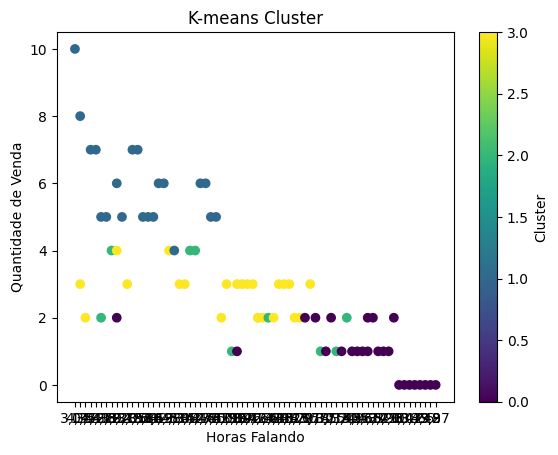

In [105]:
clustered_data_pd = clustered_data.toPandas()

# Resultados
plt.scatter(clustered_data_pd["HORAS_FALANDO"], clustered_data_pd["QTDE_VENDA"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("Horas Falando")
plt.ylabel("Quantidade de Venda")
plt.title("K-means Cluster")
plt.colorbar().set_label("Cluster")
plt.show()

In [100]:
clustered_data.head(3)

[Row(ID_AGENTE=20931, HORAS_LOGADO='6,32', HORAS_FALANDO='3,07', %_TEMPO_FALADO='0,49', QTDE_VENDA=10, QTDE_LINHA=11, QTDE_LIGACOES=103, %_CONVERSAO_VENDA='0,1', RANKING=1, Quartile=1, features=DenseVector([20931.0, 10.0, 11.0, 103.0, 1.0, 1.0]), scaled_features=DenseVector([137.003, 4.5764, 4.4738, 2.4368, 0.0447, 0.7005]), cluster=1),
 Row(ID_AGENTE=20920, HORAS_LOGADO='8,79', HORAS_FALANDO='4,35', %_TEMPO_FALADO='0,49', QTDE_VENDA=8, QTDE_LINHA=8, QTDE_LIGACOES=87, %_CONVERSAO_VENDA='0,09', RANKING=2, Quartile=1, features=DenseVector([20920.0, 8.0, 8.0, 87.0, 2.0, 1.0]), scaled_features=DenseVector([136.931, 3.6611, 3.2537, 2.0582, 0.0894, 0.7005]), cluster=1),
 Row(ID_AGENTE=20971, HORAS_LOGADO='2,24', HORAS_FALANDO='1,54', %_TEMPO_FALADO='0,69', QTDE_VENDA=2, QTDE_LINHA=3, QTDE_LIGACOES=30, %_CONVERSAO_VENDA='0,07', RANKING=3, Quartile=1, features=DenseVector([20971.0, 2.0, 3.0, 30.0, 3.0, 1.0]), scaled_features=DenseVector([137.2648, 0.9153, 1.2201, 0.7097, 0.1341, 0.7005]), clus

In [101]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)

In [102]:
wssse,output

(0.42327641531957066,
 DataFrame[ID_AGENTE: int, HORAS_LOGADO: string, HORAS_FALANDO: string, %_TEMPO_FALADO: string, QTDE_VENDA: int, QTDE_LINHA: int, QTDE_LIGACOES: int, %_CONVERSAO_VENDA: string, RANKING: int, Quartile: int, features: vector, scaled_features: vector, prediction: int])